In [421]:
import sys

from os.path import dirname, abspath
import os
sys.path.append(dirname(abspath(os.getcwd())))
import gymnasium as gym
import gymnasium.vector
import torch
import gym_usv
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video
import tempfile
from tqdm import tqdm
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
#sns.set_theme()
import matplotlib
import matplotlib as mpl
from matplotlib.collections import EllipseCollection
from torch.distributions.normal import Normal
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.vec_env import DummyVecEnv
import pickle
import numpy as np
import usv_libs_py as usv

# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

In [422]:
# Implement perturb func with step
def perturb_func(step):
    Ix = 0
    Iy = 10 if 100 < step < 150 else 0
    Iz = 20 if 100 < step < 150 else 0
    return np.zeros(3)
    return np.array([Ix, Iy, Iz])

In [423]:
def make_env():
    params = usv.controller.AITSMC.defaultParams()
    params.k_r = 0.75
    params.kmin_r = 0.001
    params.mu_r = 0.025
    params.mu_u = 0.01
    env = gym.make('usv-aitsmc-simple', render_mode="rgb_array", options={
        'params': params,
        'lambda_ye': 0.5,
        'place_obstacles_on_path': 100,
        'perturb_func': perturb_func
    }, max_episode_steps=4000)
    #env = gym.wrappers.FrameStack(env, 5)
    #env = VecFrameStack(env, 5)
    return env

envs = DummyVecEnv(
        [make_env for i in range(1)]
    )
envs = VecFrameStack(envs, 5)
model = SAC.load('model')

max_y = 10
min_y = -10
max_x = 30
min_x = -10

Using perturb func


/Users/abiel/mambaforge/envs/sb3/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/Users/abiel/Documents/Vanttec/ML/stable-baselines3-caps/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: Can't get attribute '_make_function' on <module 'cloudpickle.cloudpickle' from '/Users/abiel/mambaforge/envs/sb3/lib/python3.10/site-packages/cloudpickle/cloudpickle.py'>
  warnings.warn(


In [424]:
make_env().observation_space.shape

Using perturb func


(47,)

In [425]:
#params.k_r = 1

obs = envs.reset()
lstm_states = None

from gymnasium.wrappers.monitoring import video_recorder
recorder = video_recorder.VideoRecorder(
    envs.envs[0],
    "test_video.mp4"
)

all_info = []

for step in tqdm(range(1000)):
    action, lstm_states = model.predict(
        obs, state=lstm_states)
    action[0][1] *= 3
    action[0][0] *= 0.5
    obs, reward, terminated, infos = envs.step(action)
    infos = infos[0]
    infos['reward'] = reward
    all_info.append(infos)
    done = terminated
    if done.all():
        break
    recorder.capture_frame()

recorder.close()
Video("test_video.mp4")

/Users/abiel/mambaforge/envs/sb3/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:210: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
 24%|███████████████████▎                                                             | 238/1000 [00:00<00:01, 556.64it/s]


Moviepy - Building video test_video.mp4.
Moviepy - Writing video test_video.mp4



Moviepy - Done !
Moviepy - video ready test_video.mp4


In [426]:
from collections import defaultdict
data = defaultdict(list)
keys_to_import = ['position', 
                  'velocity',
                  'left_thruster', 
                  'right_thruster', 
                  'reward', 
                  'action0', 
                  'action1', 
                  'setpoint_u',
                  'setpoint_r',
                  'e_u', 
                  'e_r',
                  'Ka_u',
                  'Ka_r', 
                  'ye', 
                  'angle_to_target',
                  'setpoint_u',
                  'setpoint_r',
                  'ye_reward',
                  'angle_to_target_reward',
                  'angle_action_reward',
                  'delta_action_reward',
                  'velocity_towards_target',
                  'velocity_track_reward',
                  'reference_velocity_error',
                  'reference_velocity',
                  'reward_velocity',
                  'delta_action',
                  'perturb']
for info in all_info:
    for k, v in info.items():
        if k in keys_to_import:
            data[k].append(v)
df = pd.DataFrame.from_dict(data, orient='index').transpose().dropna()
df = pd.concat([df, pd.DataFrame(df['position'].to_list(), columns=['x','y','rot'])], axis=1)
df = pd.concat([df, pd.DataFrame(df['velocity'].to_list(), columns=['u','v','r'])], axis=1)
df = pd.concat([df, pd.DataFrame(df['perturb'].to_list(), columns=['perturb_tx','perturb_ty','perturb_tz'])], axis=1)
#df.left_thruster = df.left_thruster.explode()
#df.right_thruster = df.right_thruster.explode()
#df.reward = df.reward.explode()
df['action0'] = df['action0'].explode()
df['action1'] = df['action1'].explode()
df['time'] = df.index * (1/50)
df.drop(columns=['position', 'velocity'])
df.head()

,position,velocity,reward,action0,action1,left_thruster,right_thruster,ye,angle_to_target,ye_reward,...,x,y,rot,u,v,r,perturb_tx,perturb_ty,perturb_tz,time
0,"[6.019260406494141, 5.832427024841309, 1.47472...","[3.499829472275451e-05, -2.57699696248892e-07,...",[1.878844],0.358432,0.107649,0.01756,0.012954,-0.0,0.150697,1.25,...,6.019260,5.832427,1.474725,0.000035,-2.576997e-07,0.000010,0.0,0.0,0.0,0.00
1,"[6.019260406494141, 5.832430362701416, 1.47472...","[0.00011090286716353148, -5.322481229086407e-0...",[1.8932301],0.377804,0.012878,0.031727,0.031577,-0.000001,0.150697,1.249996,...,6.019260,5.832430,1.474725,0.000111,-5.322481e-07,0.000022,0.0,0.0,0.0,0.02
2,"[6.019260406494141, 5.832438945770264, 1.47472...","[0.00023035226331558079, -1.7202978597197216e-...",[1.8689992],0.433681,0.393735,0.060562,0.034992,-0.000004,0.150698,1.249986,...,6.019260,5.832439,1.474728,0.000230,-1.720298e-06,0.000070,0.0,0.0,0.0,0.04
3,"[6.019262790679932, 5.832454204559326, 1.47473...","[0.0003910823434125632, -3.695955911098281e-06...",[1.8828988],0.44631,0.368966,0.085581,0.042127,-0.000012,0.150701,1.249962,...,6.019263,5.832454,1.474733,0.000391,-3.695956e-06,0.000150,0.0,0.0,0.0,0.06
4,"[6.019265174865723, 5.8324785232543945, 1.4747...","[0.0005895610665902495, -6.725185357936425e-06...",[1.8759614],0.449977,0.538864,0.113911,0.043153,-0.000023,0.150705,1.249927,...,6.019265,5.832479,1.474743,0.000590,-6.725185e-06,0.000272,0.0,0.0,0.0,0.08


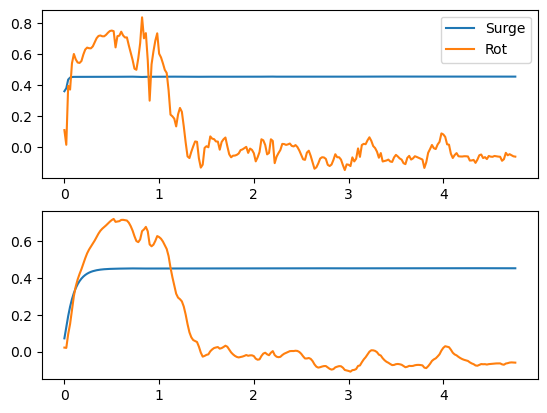

In [427]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(df.time, df.action0, label="Surge")
ax1.plot(df.time, df.action1, label="Rot")
ax1.legend()
ax2.plot(df.time, df.setpoint_u, label="Filtered Surge")
ax2.plot(df.time, df.setpoint_r, label="Filtered Rot")

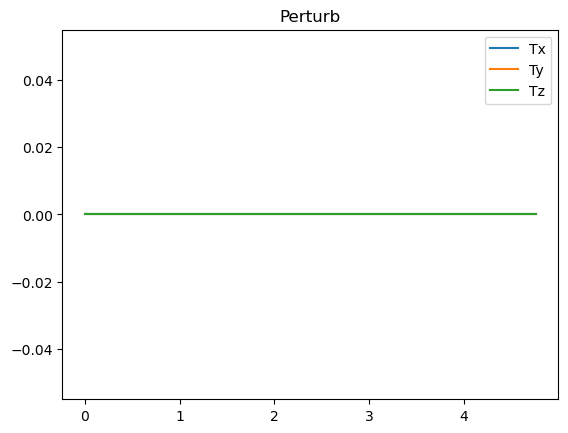

In [428]:
fig, ax1 = plt.subplots()
ax1.plot(df.time, df.perturb_tx, label="Tx")
ax1.plot(df.time, df.perturb_ty, label="Ty")
ax1.plot(df.time, df.perturb_tz, label="Tz")
ax1.set_title("Perturb")
ax1.legend()

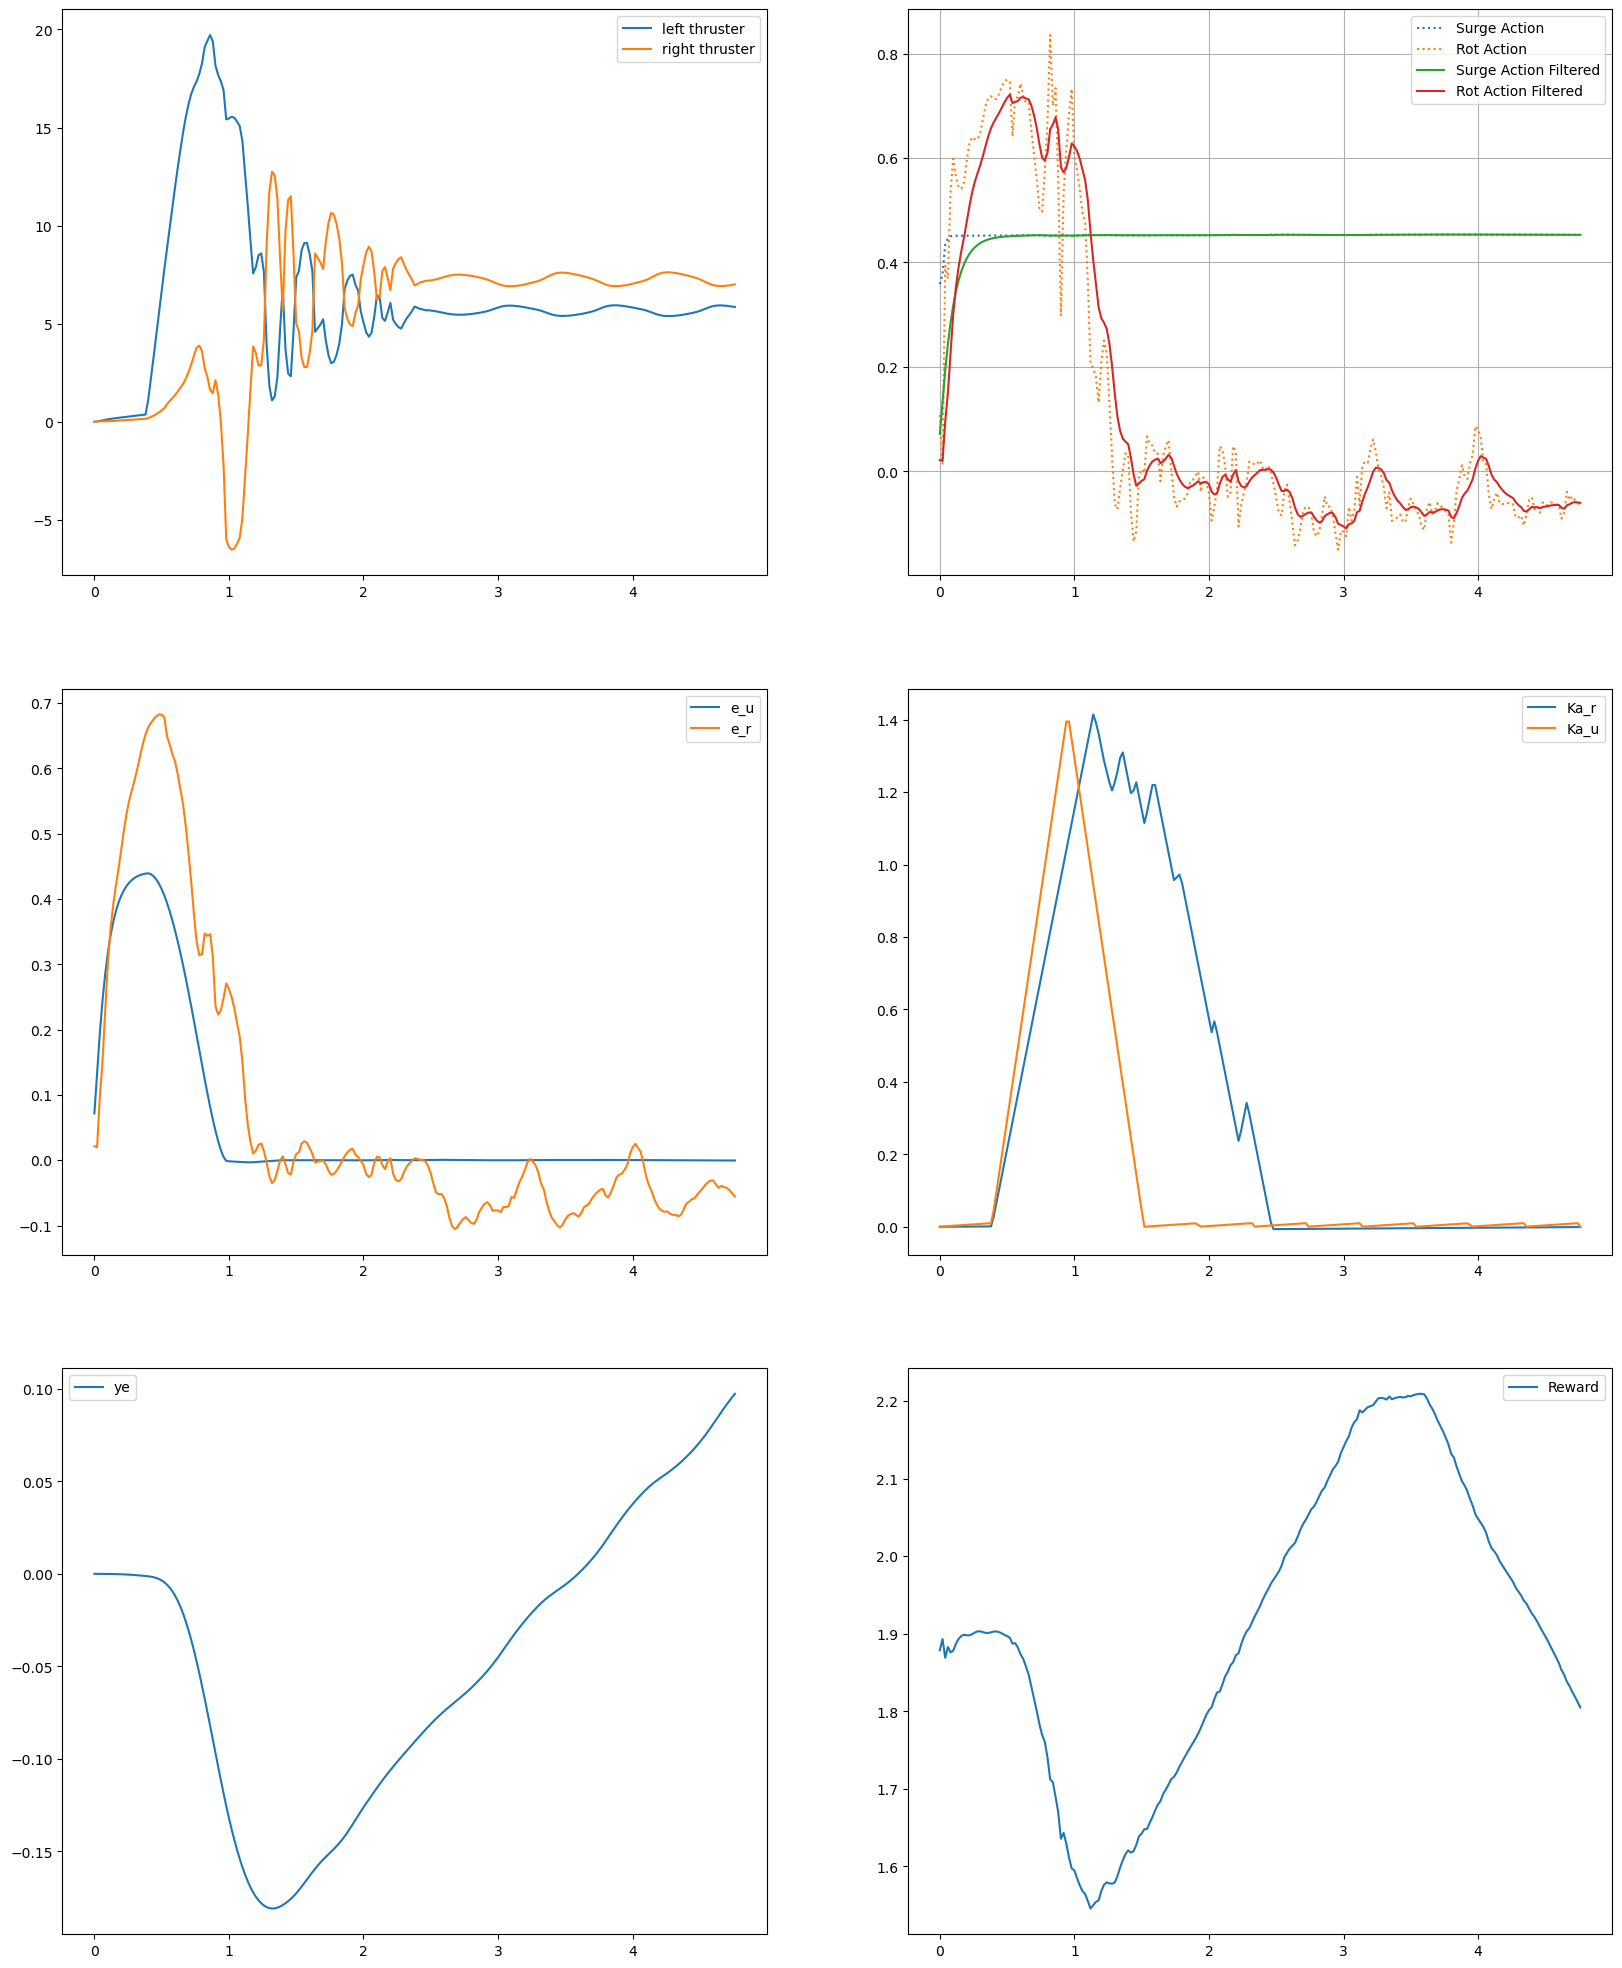

In [429]:
fig, axes = plt.subplots(3,2, figsize=(20,25))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
ax1.plot(df.time, df['left_thruster'], ls="-", label="left thruster")
ax1.plot(df.time, df['right_thruster'], ls="-", label="right thruster")
ax1.legend()

ax2.plot(df.time, df['action0'], ls=":", label="Surge Action")
ax2.plot(df.time, df['action1'], ls=":", label="Rot Action")
ax2.plot(df.time, df['setpoint_u'], ls="-", label="Surge Action Filtered")
ax2.plot(df.time, df['setpoint_r'], ls="-", label="Rot Action Filtered")
ax2.legend()
ax2.grid()

ax3.plot(df.time, df['e_u'], ls="-", label="e_u")
ax3.plot(df.time, df['e_r'], ls="-", label="e_r")
ax3.legend()

ax4.plot(df.time, df['Ka_r'], ls="-", label="Ka_r")
ax4.plot(df.time, df['Ka_u'], ls="-", label="Ka_u")
ax4.legend()

ax5.plot(df.time, df['ye'], label="ye")
ax5.legend()

ax6.plot(df.time, df['reward'], label='Reward')
ax6.legend()

/var/folders/vs/v598jthd5m394xwn82kr_xrr0000gn/T/ipykernel_45920/3778893001.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


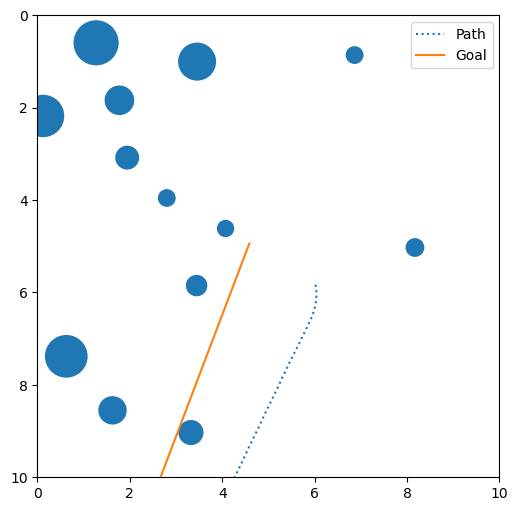

In [430]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(df.x, df.y, ':', label="Path")

start_pos, end_pos = envs.envs[0].path_start, envs.envs[0].path_end
obstacle_positions = envs.envs[0].obstacle_positions
obstacle_radius = envs.envs[0].obstacle_radius

obstacles_rotated = obstacle_positions.copy()
ax.add_collection(EllipseCollection(widths=obstacle_radius*2, heights=obstacle_radius*2, angles=0, units='xy',
                                       offsets=obstacles_rotated, transOffset=ax.transData))

ax.plot((start_pos[0], end_pos[0]), (start_pos[1], end_pos[1]), label="Goal")
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.legend()
#plt.gca().invert_yaxis()
ax.set_aspect('equal')
ax.invert_yaxis()
fig.show()

#plt.savefig('figures/experiment1_path.pgf')


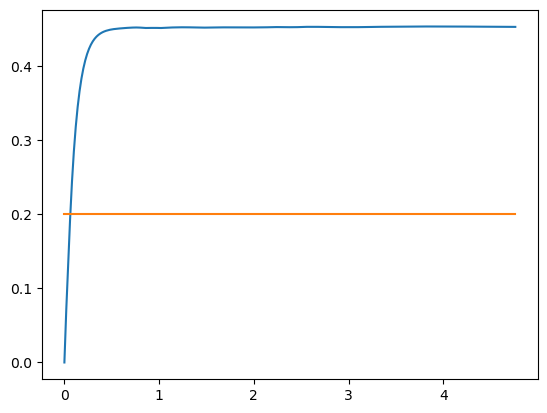

In [431]:
fig, ax = plt.subplots()
ax.plot(df.time, df.reward_velocity)
ax.plot(df.time, df.reference_velocity)

IndexError: invalid index to scalar variable.

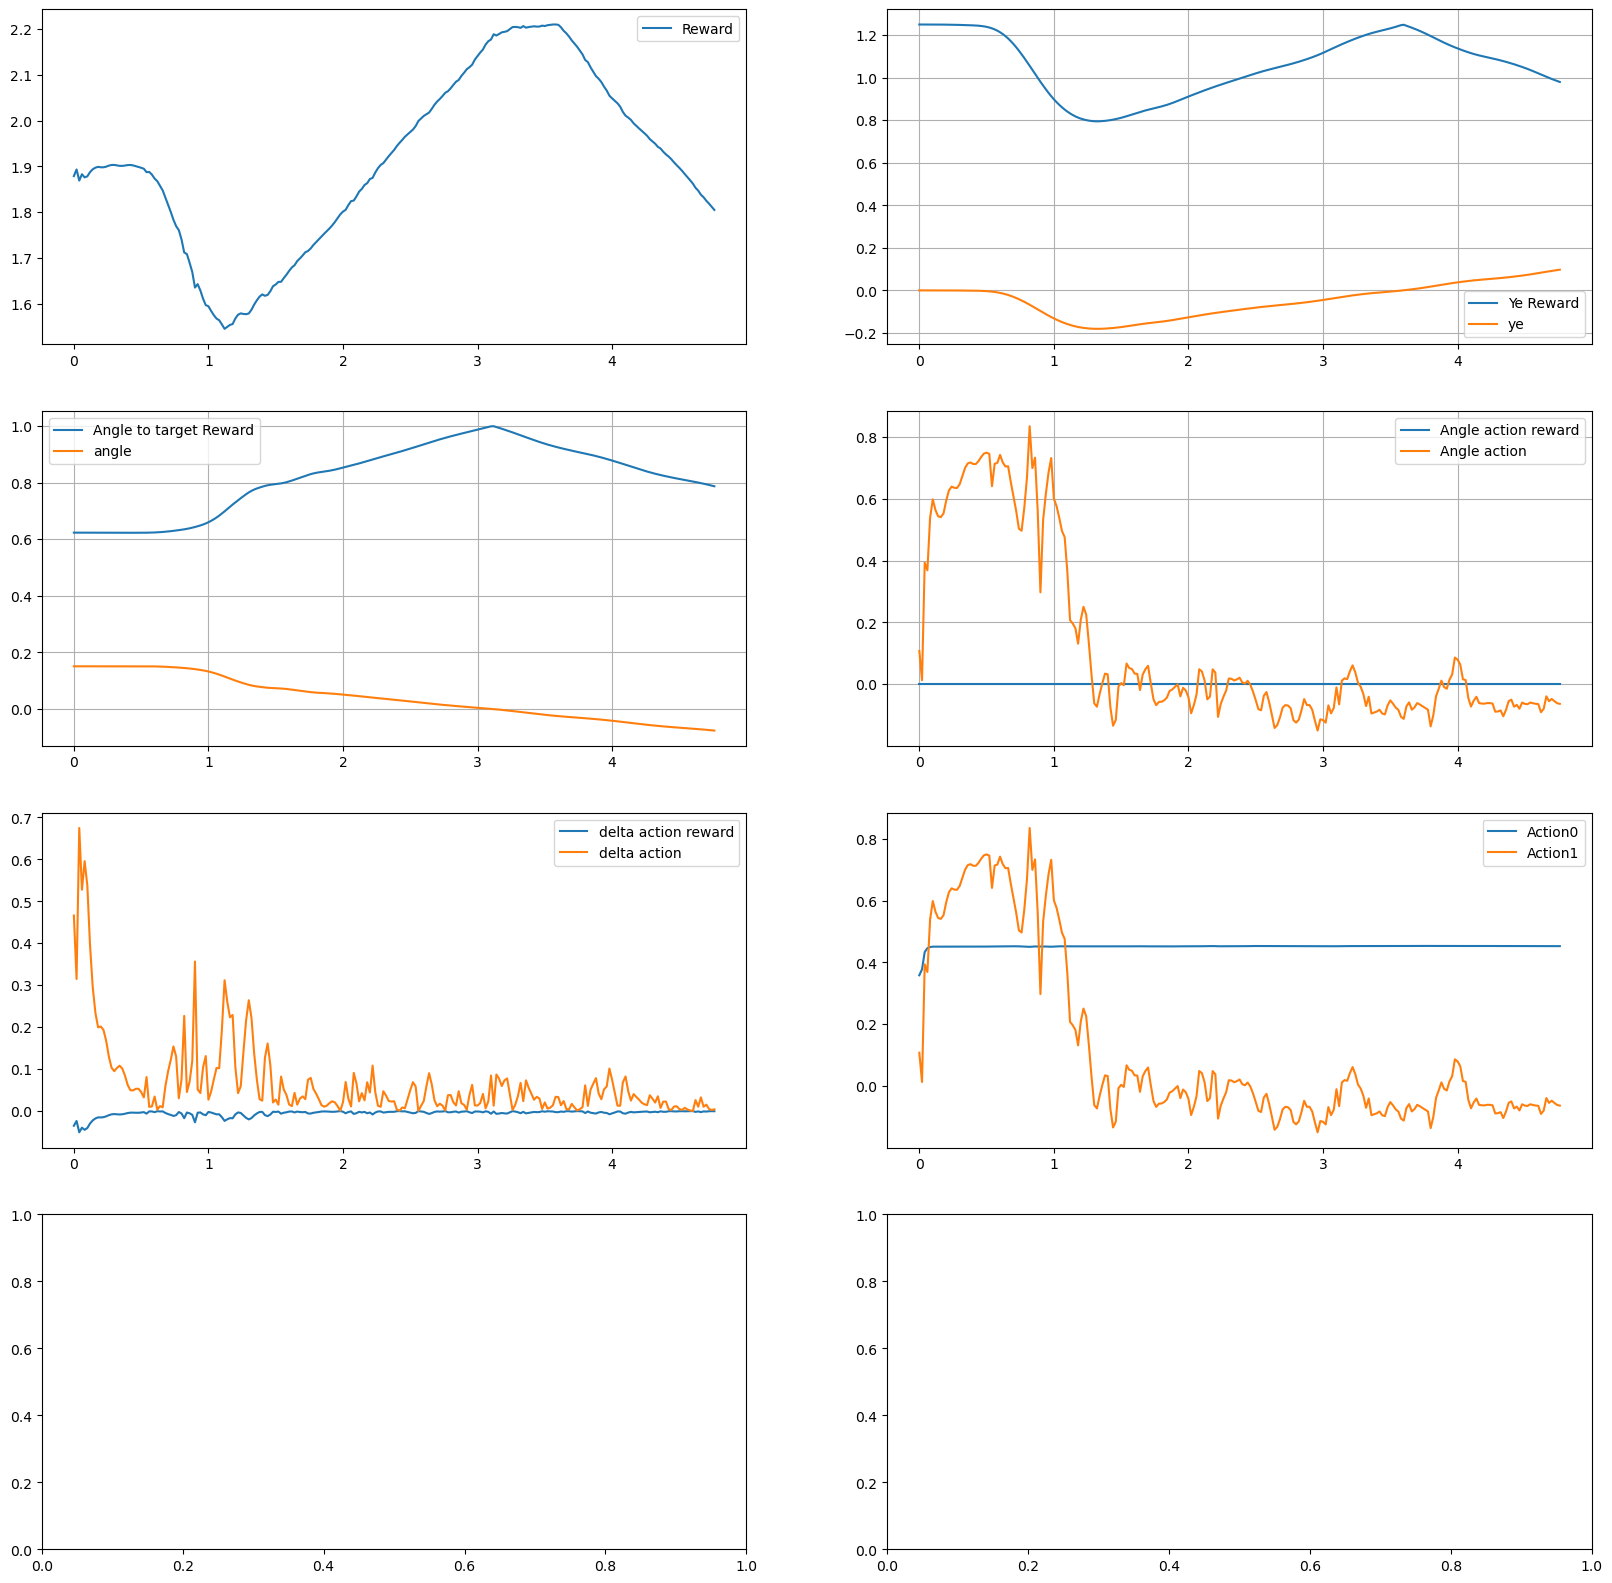

In [432]:
fig, axes = plt.subplots(4, 2, figsize=(20,20))
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.flatten()
ax1.plot(df.time, df['reward'], ls="-", label="Reward")
ax1.legend()

#ax2.plot(df.time, df['ye'], ls="-", label="Ye")
ax2.plot(df.time, df['ye_reward'], ls="-", label="Ye Reward")
ax2.plot(df.time, df['ye'], label="ye")
ax2.grid()
ax2.legend()

ax3.plot(df.time, df['angle_to_target_reward'], label='Angle to target Reward')
ax3.plot(df.time, df.angle_to_target, label="angle")
ax3.grid()
ax3.legend()

ax4.plot(df.time, df.angle_action_reward, label="Angle action reward")
ax4.plot(df.time, df.action1, label="Angle action")
ax4.grid()
ax4.legend()

ax5.plot(df.time, df.delta_action_reward, label="delta action reward")
ax5.plot(df.time, df.delta_action, label="delta action")
ax5.legend()

ax6.plot(df.time, df.action0, label="Action0")
ax6.plot(df.time, df.action1, label="Action1")
ax6.legend()

angles = df.angle_to_target.apply(lambda x: x[0]).to_numpy()
ax7.plot(df.time, df.reference_velocity_error, label="Error")
ax7.plot(df.time, df.velocity_track_reward, label="Velocity track reward")
ax7.legend()

ax8.plot(df.time, df.reference_velocity, label="Reference Velocity")
ax8.plot(df.time, df.reward_velocity, label="Velocity")
ax8.legend()
#ax7.plot(df.time, df.action0, label="Velocity")
